<a href="https://colab.research.google.com/github/JGPB0/CS/blob/main/Lab8/CS_Lab8_ParedesJimmy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packet Sniffing and Spoofing Lab
## Paredes Jimmy

## Using Scapy to Sniff and Spoof Packets



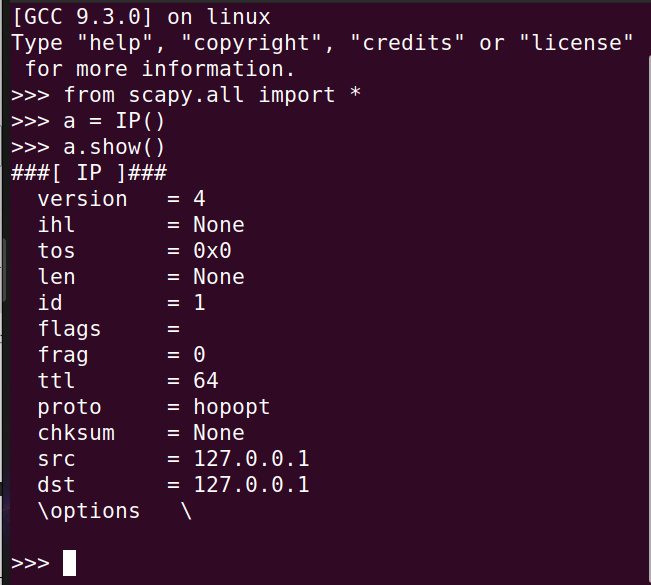

It is possible to observe that the lines of code above using the Scapy module is used to create an IP and show the result of it.

## Task 1.1: Sniffing Packets

### Task 1.1A. In the above program, for each captured packet, the callback function print pkt() will be invoked; this function will print out some of the information about the packet. Run the program with the root privilege and demonstrate that you can indeed capture packets. After that, run the program again, but without using the root privilege; describe and explain your observations.




When running the program with root privileges, it seems to be sniffing the packets, to test it, it can be used ping command line and specifying the iface used.

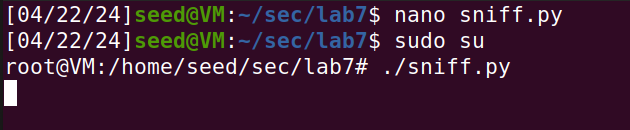

On the other hand, when running the program without root privileges (from seed terminal) the following erorr is obatined due to permissions needed for sniffing packets.

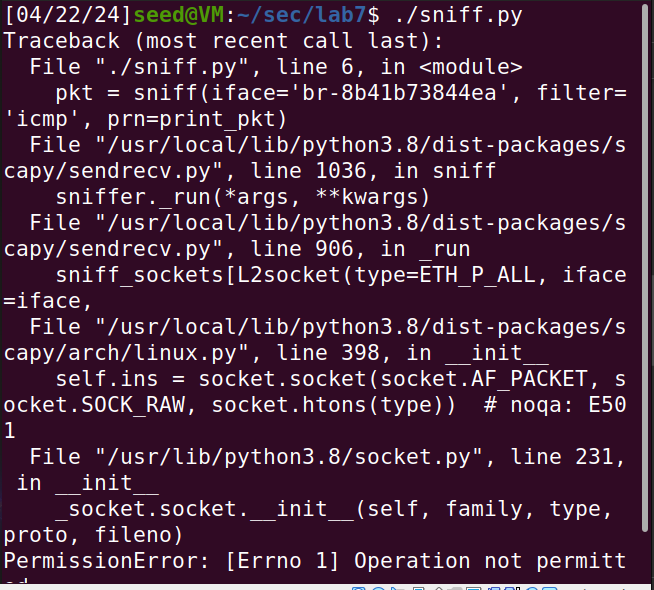

As it is possible to see in the figure above, explains that the operation we are trying to perform is not permitted to this user.

It is important to notice that the **iface** used in the sniff.py file was br-8b41b73844ea because this vas obtained from the command line:

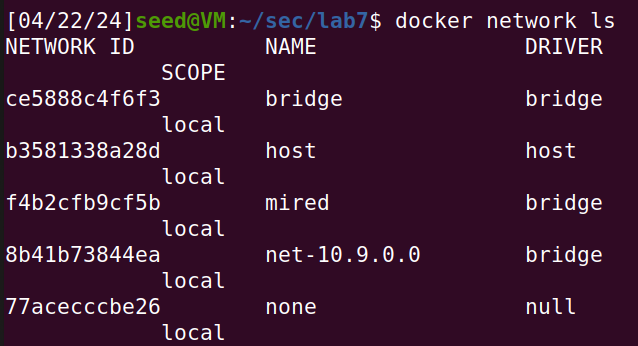

### Task 1.1B. Usually, when we sniff packets, we are only interested certain types of packets. We can do that by setting filters in sniffing. Scapy’s filter use the BPF (Berkeley Packet Filter) syntax; you can find the BPF manual from the Internet. Please set the following filters and demonstrate your sniffer program again (each filter should be set separately):
* Capture only the ICMP packet
* Capture any TCP packet that comes from a particular IP and with a destination port number 23.
* Capture packets comes from or to go to a particular subnet. You can pick any subnet, such as 128.230.0.0/16; you should not pick the subnet that your VM is attached to.

In [ ]:
# to capture only the ICMP packet:

from scapy.all import *

def sniff_icmp():
    print("Sniffing ICMP packets...")
    sniff(filter="icmp", prn=lambda x: x.summary())

sniff_icmp()

In [ ]:
# to capture any TCP packet that comes from a particular
# Ip and with a destination port number 23:

from scapy.all import *

def sniff_tcp_from_ip_to_port(ip_address, port):
    filter_str = f"tcp and src host {ip_address} and dst port {port}"
    print(f"Sniffing TCP packets from {ip_address} to port {port}...")
    sniff(filter=filter_str, prn=lambda x: x.summary())

sniff_tcp_from_ip_to_port("192.168.1.100", 23)

In [ ]:
# to capture packets coming from or going to a particular subnet:

from scapy.all import *

def sniff_subnet(subnet):
    filter_str = f"net {subnet}"
    print(f"Sniffing packets from/to subnet {subnet}...")
    sniff(filter=filter_str, prn=lambda x: x.summary())

sniff_subnet("128.230.0.0/16")

So, the codes above are created for every different escenario asked.

## Task 1.2: Spoofing ICMP Packets

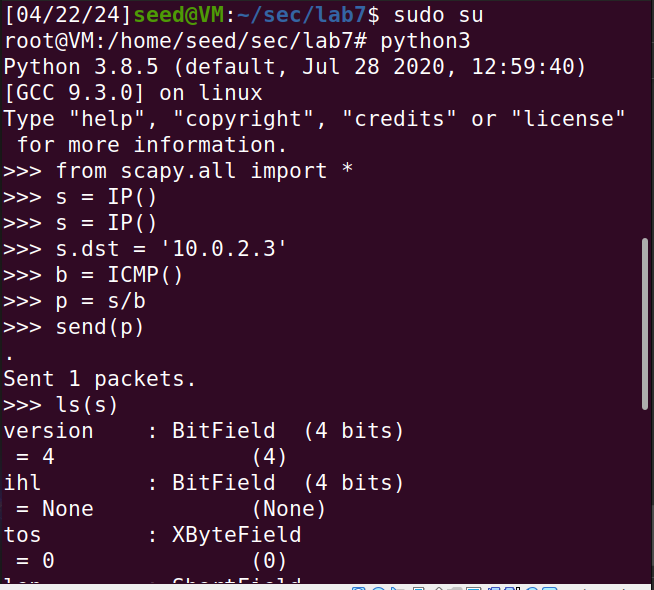


Here it is represented how to send a packet to a specific destination. It is important to take into account that to send the packets it is necesary to have root privileges as it was explained above.

## Task 1.3: Traceroute

The following result was obtained by creating a python program:


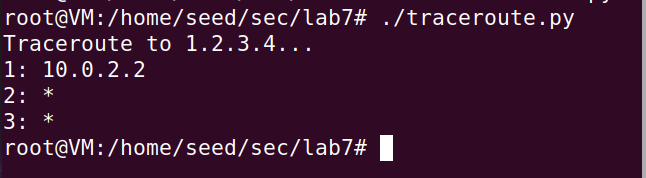

In this case, it prints the ports that returns a response, otherwise it prints *.

In [ ]:
# the python program is the following:

#!/usr/bin/env python3
from scapy.all import *

def traceroute(destination, max_hops=3):
    print(f"Traceroute to {destination}...")

    ttl = 1

    while ttl <= max_hops:
        packet = IP(dst=destination, ttl=ttl)
        reply = sr1(packet / ICMP(), timeout=1, verbose=False)

        # If we receive a response, print the IP address
        if reply:
            print(f"{ttl}: {reply.src}")
            if reply.src == destination:
                break
        else:
            # If we don't receive a response, print *
            print(f"{ttl}: *")

        ttl += 1

if __name__ == "__main__":
    destination = "1.2.3.4"
    traceroute(destination)


## Task 1.4: Sniffing and-then Spoofing

### In your experiment, you should ping the following three IP addresses from the user container. Report your observation and explain the results.



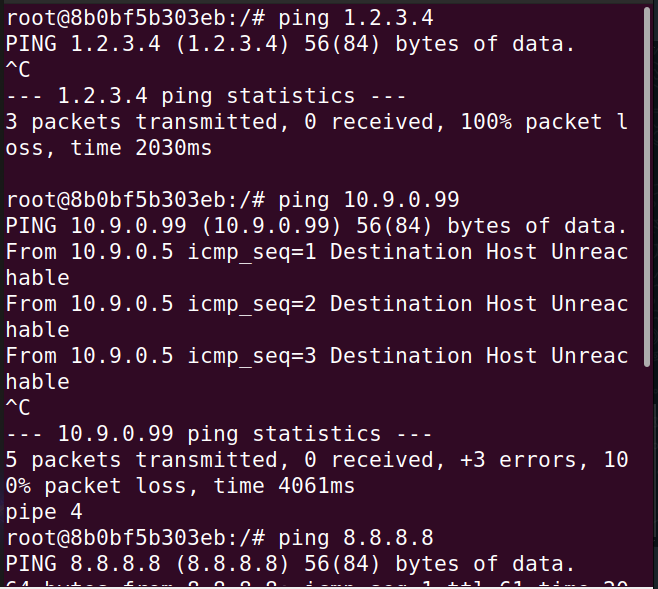


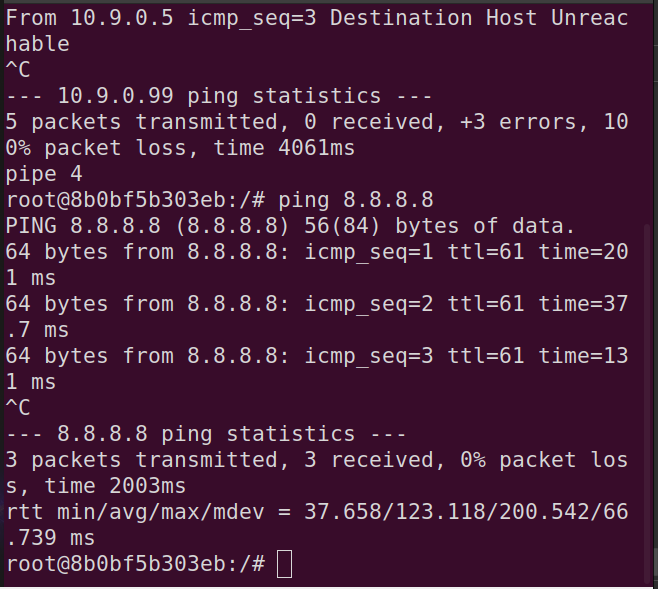

From the figures above, we can see that the result obtained using the ping command is different with every IP direction. In the first one nothing is received or transmitted because the host does not exist on the Internet. On the second example, it returns the message that the host is unreachable, because the host does not exist on the LAN. Finally, on the third one, it starts to transmit and receive packets, this is becase this host exists on the Internet.

## Lab Task Set 2: Writing Programs to Sniff and Spoof Packets

### Task 2.1: Writing Packet Sniffing Program

The packet Sniffing program in C was written successfully following the instructions.


### Task 2.1A: Understanding How a Sniffer Works

The following C code was created to perform the task:

In [ ]:
#include <stdio.h>
#include <pcap.h>
#include <netinet/ip.h>
#include <arpa/inet.h>
#include <netinet/ip.h>
#include <arpa/inet.h>

void packet_handler(u_char *user_data, const struct pcap_pkthdr *pkthdr, const u_char *packet) {
    struct ip *ip_header = (struct ip *)packet;

    printf("Source IP: %s\n", inet_ntoa(ip_header->ip_src));
    printf("Destination IP: %s\n", inet_ntoa(ip_header->ip_dst));
}


int main() {
    pcap_t *handle;
    char errbuf[PCAP_ERRBUF_SIZE];

    // Open the network interface for packet capture
    handle = pcap_open_live("br-8b41b73844ea", BUFSIZ, 1, 1000, errbuf);

    if (handle == NULL) {
        fprintf(stderr, "Couldn't open device: %s\n", errbuf);
        return 1;
    }

    // Compile and set the packet filter
    struct bpf_program fp;
    char filter_exp[] = "ip";
    if (pcap_compile(handle, &fp, filter_exp, 0, PCAP_NETMASK_UNKNOWN) == -1) {
        fprintf(stderr, "Couldn't parse filter %s: %s\n", filter_exp, pcap_geterr(handle));
        return 1;
    }
    if (pcap_setfilter(handle, &fp) == -1) {
        fprintf(stderr, "Couldn't install filter %s: %s\n", filter_exp, pcap_geterr(handle));
        return 1;
    }

    // Capture packets
    pcap_loop(handle, 0, packet_handler, NULL);

    pcap_close(handle);
    return 0;
}


And then, the following lines of code were used:
```
gcc -o sniff.out sniffing.c -lpcap
```
being sniffing.c the file containing the code above.
In order to copy the executable file into the atacker docker:

```
docker cp sniff.out 82e73160c888:/tmp
```

So, the sniff.out file must be executed into the attacker terminal.


In addition, please answer the following questions:
  * Question 1. Please use your own words to describe the sequence of the library calls that are essential for sniffer programs. This is meant to be a summary, not detailed explanation like the one in the tutorial or book.

      * pcap_open_live(): Opens a live capture handle on a network interface.
      * pcap_compile(): Compiles a filter expression into a BPF (Berkeley Packet Filter) program.
      * pcap_setfilter(): Sets the compiled filter program on the capture handle to capture specific types of packets.
      * pcap_loop() or pcap_dispatch(): Enters a loop to capture packets asynchronously or synchronously.
      * packet_handler(): Callback function called for each captured packet.
      * Inside packet_handler(), various functions can be used to extract and process packet data.

  * Question 2. Why do you need the root privilege to run a sniffer program? Where does the program fail if it is executed without the root privilege?

  It indeed needs to have root privileges because if does not have the necessary privileges and can not be put into promiscuous mode  , the device is not accessible to sniff the packets. Running the executable file sithput root privileges, the following error is presented: **br-8b41b73844ea: You don't have permission to capture on that device (socket: Operation not permitted)**

  * Question 3. Please turn on and turn off the promiscuous mode in your sniffer program. The value 1 of the third parameter in pcap open live() turns on the promiscuous mode (use 0 to turn it off). Can you demonstrate the difference when this mode is on and off? Please describe how you can demonstrate this. You can use the following command to check whether an interface’s promiscuous mode is on or off (look at the promiscuity’s value).
```
  # ip -d link show dev br-f2478ef59744
  1249: br-f2478ef59744: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 1500 ...
  link/ether 02:42:ac:99:d1:88 brd ff:ff:ff:ff:ff:ff promiscuity 1 ...
```
    * To turn on promiscuous mode, set the third parameter of pcap_open_live() to 1.
    * To turn off promiscuous mode, set the third parameter to 0.




### Task 2.1B: Writing Filters.
Please write filter expressions for your sniffer program to capture each of the followings.

* Capture the ICMP packets between two specific hosts.
  * icmp and (host host1 and host host2), where **host1** and **host2** refer to the IP address of the hosts we want to capture ICMP packets.

* Capture the TCP packets with a destination port number in the range from 10 to 100.
  * tcp dst portrange 10-100

For both cases, the changes have to be done with the **pcap_compile()** function to compile them into BPF programs, and then set the compiled filter programs on the capture handle using **pcap_setfilter()** in the C program explained before.

### Task 2.2: Spoofing


### Task 2.2A: Write a spoofing program.
The following C code was created as a spoofing program:

In [ ]:
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <unistd.h>
#include <arpa/inet.h>
#include <netinet/ip.h>
#include <netinet/tcp.h>

#define PACKET_LEN 1024

// IP header structure
struct ipheader {
    unsigned char ip_hl:4, ip_v:4;
    unsigned char ip_tos;
    unsigned short ip_len;
    unsigned short ip_id;
    unsigned short ip_off;
    unsigned char ip_ttl;
    unsigned char ip_p;
    unsigned short ip_sum;
    unsigned int ip_src;
    unsigned int ip_dst;
};

// TCP header structure
struct tcpheader {
    unsigned short th_sport;
    unsigned short th_dport;
    unsigned int th_seq;
    unsigned int th_ack;
    unsigned char th_off:4, th_x2:4;
    unsigned char th_flags;
    unsigned short th_win;
    unsigned short th_sum;
    unsigned short th_urp;
};

unsigned short checksum(unsigned short *buf, int nwords) {
    unsigned long sum;
    for (sum = 0; nwords > 0; nwords--) sum += *buf++;
    sum = (sum >> 16) + (sum & 0xffff);
    sum += (sum >> 16);
    return ~sum;
}

int main() {
    int sockfd;
    char packet[PACKET_LEN];
    struct ipheader *iph = (struct ipheader *) packet;
    struct tcpheader *tcph = (struct tcpheader *) (packet + sizeof(struct ipheader));

    struct sockaddr_in sin;

    // Create raw socket
    sockfd = socket(AF_INET, SOCK_RAW, IPPROTO_RAW);
    if (sockfd < 0) {
        perror("socket() error");
        return 1;
    }

    // Set IP header fields
    iph->ip_hl = 5;
    iph->ip_v = 4;
    iph->ip_tos = 0;
    iph->ip_len = sizeof(struct ipheader) + sizeof(struct tcpheader);
    iph->ip_id = htonl(54321);
    iph->ip_off = 0;
    iph->ip_ttl = 255;
    iph->ip_p = IPPROTO_TCP;
    iph->ip_sum = 0;
    iph->ip_src = inet_addr("192.168.1.1"); // Spoofed source IP address
    iph->ip_dst = inet_addr("192.168.1.2"); // Destination IP address

    // Set TCP header fields
    tcph->th_sport = htons(1234);
    tcph->th_dport = htons(80);
    tcph->th_seq = htonl(0);
    tcph->th_ack = htonl(0);
    tcph->th_off = 5;
    tcph->th_flags = TH_SYN;
    tcph->th_win = htons(5840);
    tcph->th_sum = 0;
    tcph->th_urp = 0;

    // Calculate TCP checksum
    tcph->th_sum = checksum((unsigned short *) packet, sizeof(struct ipheader) + sizeof(struct tcpheader));

    // Fill in the sockaddr_in structure
    sin.sin_family = AF_INET;
    sin.sin_port = htons(80);
    sin.sin_addr.s_addr = iph->ip_dst;

    // Send the packet
    if (sendto(sockfd, packet, iph->ip_len, 0, (struct sockaddr *) &sin, sizeof(sin)) < 0) {
        perror("sendto() error");
        return 1;
    }

    printf("Spoofed packet sent.\n");

    close(sockfd);

    return 0;
}

### Task 2.2B: Spoof an ICMP Echo Request.


* Can you set the IP packet length field to an arbitrary value, regardless of how big the actual packet is?
  
  No, you cannot set the IP packet length field to an arbitrary value. The IP packet length field should reflect the actual size of the IP packet, including the IP header and payload.

* Using the raw socket programming, do you have to calculate the checksum for the IP header?

  Yes, when constructing IP packets using raw socket programming, you typically need to calculate the checksum for the IP header. The checksum is a crucial field in the IP header that ensures the integrity of the packet

* Why do you need the root privilege to run the programs that use raw sockets? Where does the program fail if executed without the root privilege?

  It is needed because raw sockets allow you to bypass the standard network stack and send and receive packets directly on the network interface. If executed without root privilege, the program will fail when attempting to create the raw socket using the socket() system call.